## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Missing values

In [4]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
test['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
# anatom_site_general_challenge (NaN)
train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [5]:
### Label ecoding
enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train['sex'].astype('str'))
test['sex_enc'] = enc.transform(test['sex'].astype('str'))

### One-hot ecoding
# train = pd.concat([train, pd.get_dummies(train['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# test = pd.concat([test, pd.get_dummies(test['sex'], prefix='sex_enc', drop_first=True)], axis=1)

### Mean ecoding
# Sex
train['sex_mean'] = train['sex'].map(train.groupby(['sex'])['target'].mean())
test['sex_mean'] = test['sex'].map(train.groupby(['sex'])['target'].mean())


# External features
train_img_ft = pd.read_csv('../input/landscape/TrainSuperTab.csv')
test_img_ft = pd.read_csv('../input/landscape/TestSuperTab.csv')
ext_fts = ['V1', 'V2', 'V3', 'V4','V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 
           'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
           'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
for ft in ext_fts:
    train[ft] = train_img_ft[ft]
    test[ft] = test_img_ft[ft]

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,...,1.835102,1.428571,1.176471,0.368451,24.984602,1.309416,0.272855,0.098885,52.594848,0.428426
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,...,1.301577,1.666667,1.095238,0.391409,25.587810,1.240345,0.317342,0.125999,57.991760,0.430091
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,...,1.475337,1.531477,0.581197,0.209879,14.387222,1.272196,0.410767,0.138850,56.623874,0.423386
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,...,2.772424,1.000000,2.000000,0.643102,47.842749,1.504529,0.830075,0.271822,46.900691,0.425073
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,...,1.358362,1.479167,1.100000,0.361749,23.899347,1.310327,0.357306,0.125601,57.289260,0.428426


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,sex_mean,V1,V2,V3,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1,0.021231,0.1024,14,13671.8750,...,1.899913,1.250000,0.949153,0.326860,24.660825,1.384345,0.830075,0.231371,51.690459,0.426753
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.021231,0.1024,9,8789.0625,...,1.482239,1.363636,0.615385,0.184831,13.580182,1.311702,0.556334,0.186888,54.321052,0.438307
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.013766,0.1024,5,4882.8125,...,1.354060,1.666667,1.250000,0.480622,29.233718,1.236259,0.409636,0.171080,57.767034,0.425073
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.013766,0.1024,4,3906.2500,...,1.335321,1.734166,1.333333,0.626502,36.844012,1.253537,0.358360,0.153529,57.288517,0.436678
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.013766,0.1024,3,2929.6875,...,1.232224,2.222222,1.226930,0.565741,30.575912,1.260437,0.384288,0.174129,59.508983,0.425073


# Model

In [6]:
features = ['age_approx', 'sex_mean']

ohe_features  = [col for col in train.columns if 'enc' in col]

features += ohe_features

# External features
features += ext_fts
print(features)

['age_approx', 'sex_mean', 'sex_enc', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']


In [7]:
# Hyperparameter grid
param_grid = {
    'max_depth': list(range(2, 10)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.3, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'scale_pos_weight': list(np.linspace(1, (len(train[train['target'] == 0]) / len(train[train['target'] == 1])), 10)),
}


skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)

def get_idxs():
    for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
        x_train = train[train['tfrecord'].isin(idxT)]
        x_valid = train[~train['tfrecord'].isin(idxT)]
        yield x_train.index, x_valid.index


# Model
model = XGBClassifier(n_estimators=300, random_state=SEED)

grid_search = RandomizedSearchCV(param_distributions=param_grid, estimator=model, scoring='roc_auc', 
                                 cv=iter(get_idxs()), n_jobs=-1, n_iter=100, verbose=1)
result = grid_search.fit(train[features], train['target'])

print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
params = result.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 61.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 70.5min finished


Best: 0.787427 using {'subsample': 0.7323232323232324, 'scale_pos_weight': 7.080289193302892, 'reg_lambda': 0.32653061224489793, 'reg_alpha': 0.061224489795918366, 'max_depth': 3, 'learning_rate': 0.043844280472937126, 'colsample_bytree': 0.8444444444444446}
0.780880 (0.006746) with: {'subsample': 0.5757575757575758, 'scale_pos_weight': 19.240867579908677, 'reg_lambda': 0.673469387755102, 'reg_alpha': 0.9591836734693877, 'max_depth': 5, 'learning_rate': 0.02299496045261219, 'colsample_bytree': 0.9222222222222223}
0.773716 (0.009554) with: {'subsample': 0.51010101010101, 'scale_pos_weight': 43.56202435312025, 'reg_lambda': 0.6122448979591836, 'reg_alpha': 0.7755102040816326, 'max_depth': 4, 'learning_rate': 0.00635439354601029, 'colsample_bytree': 0.7666666666666666}
0.750438 (0.011813) with: {'subsample': 0.8383838383838385, 'scale_pos_weight': 43.56202435312025, 'reg_lambda': 0.4693877551020408, 'reg_alpha': 0.9591836734693877, 'max_depth': 8, 'learning_rate': 0.011785347069983637, 'c

# Training

In [8]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0
model_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'validation' if x['tfrecord'] in idxT else 'train', axis=1)    
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    model = XGBClassifier(**params, random_state=SEED)
    
    model.fit(x_train[features], y_train, eval_set=[(x_valid[features], y_valid)], 
              eval_metric='auc', early_stopping_rounds=100, verbose=0)
    model_list.append(model)

    # Evaludation
    preds = model.predict_proba(train[features])[:, 1]
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = model.predict_proba(test[features])[:, 1]
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Feature importance

Fold: 1


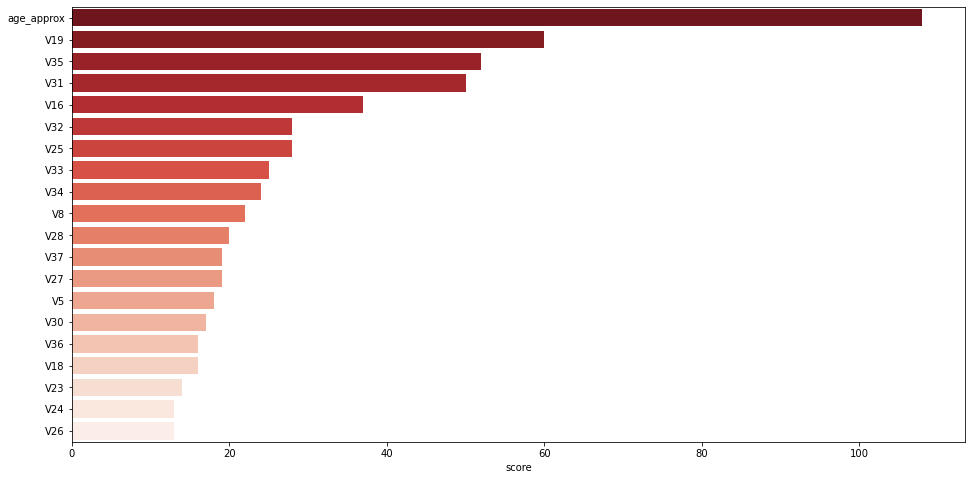

Fold: 2


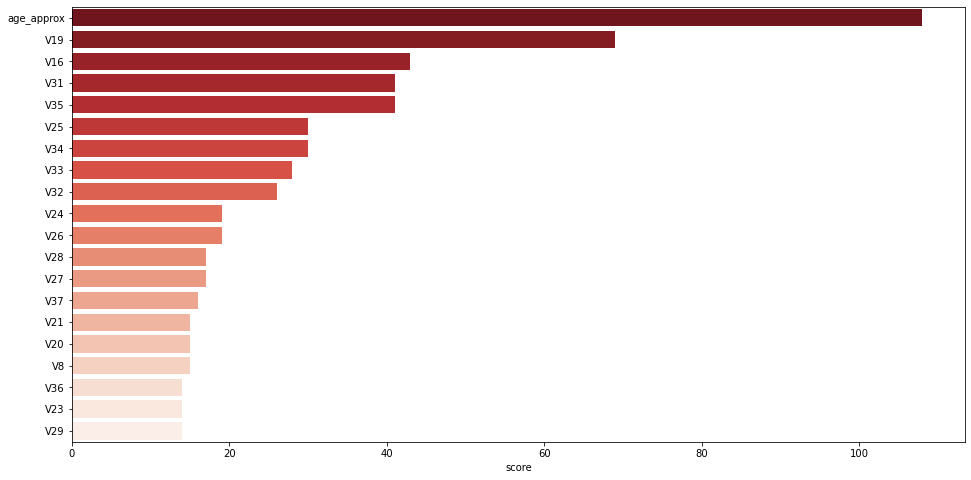

Fold: 3


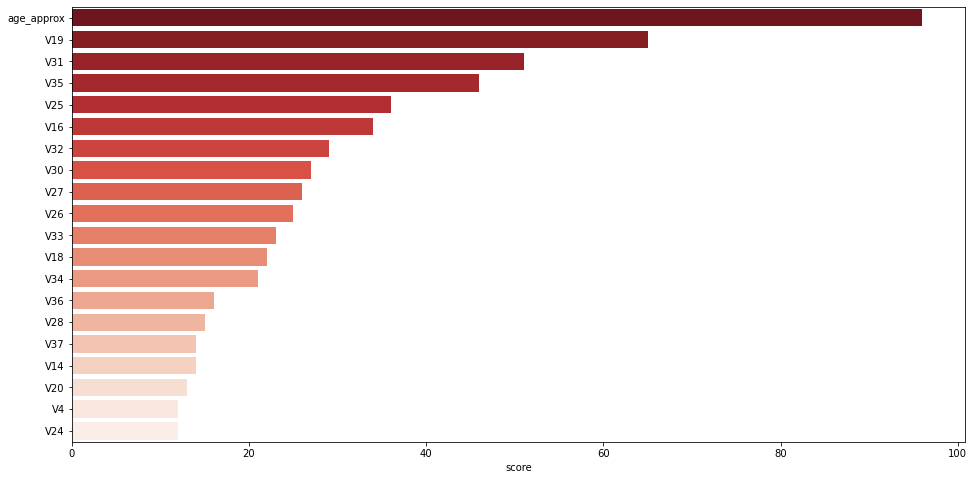

Fold: 4


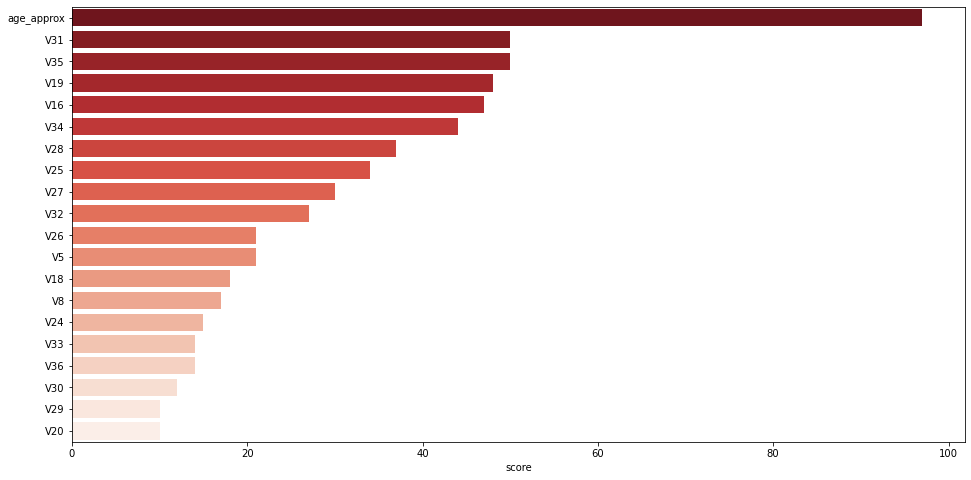

Fold: 5


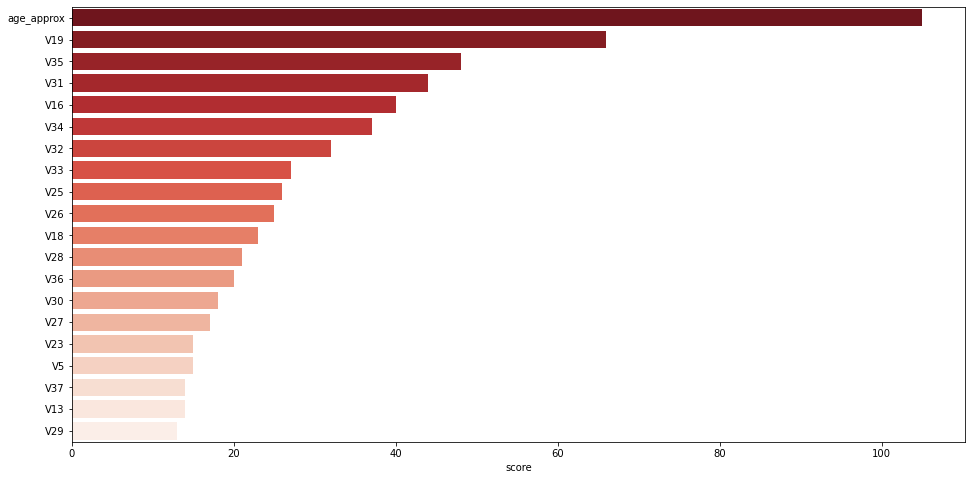

In [9]:
for n_fold, model in enumerate(model_list):
    print(f'Fold: {n_fold + 1}')
    feature_importance = model.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                              columns=['score']).sort_values(by='score',
                                                             ascending=False)
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importance.score.iloc[:20],
                y=importance.index[:20],
                orient='h',
                palette='Reds_r')

    plt.show()

# Model evaluation

In [10]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.780412,0.847426,-0.067014,0.798656,0.851594,0.765115,0.851415,0.771778,0.853102,0.779865,0.848082,0.786647,0.832938
Accuracy,0.979922,0.981425,-0.001503,0.980631,0.980999,0.978042,0.981650,0.979674,0.981867,0.981436,0.981549,0.979825,0.981061
Precision,0.155909,0.411145,-0.255237,0.214286,0.378788,0.052632,0.436975,0.151515,0.438356,0.250000,0.410000,0.111111,0.391608
Recall,0.035252,0.099407,-0.064155,0.050420,0.107527,0.016807,0.111828,0.042017,0.068817,0.042017,0.088172,0.025000,0.120690
F1-score,0.057132,0.158838,-0.101707,0.081633,0.167504,0.025478,0.178082,0.065789,0.118959,0.071942,0.145133,0.040816,0.184514
Support,119.200000,464.800000,-345.600000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,120.000000,464.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.780412,0.847426,-0.067014,0.798656,0.851594,0.765115,0.851415,0.771778,0.853102,0.779865,0.848082,0.786647,0.832938
male,0.771213,0.838989,-0.067776,0.784869,0.844143,0.788475,0.835091,0.728988,0.852094,0.759639,0.841750,0.794094,0.821865
female,0.781296,0.852805,-0.071509,0.815072,0.854657,0.717957,0.866568,0.806133,0.850265,0.800876,0.850520,0.766441,0.842017
head/neck,0.777109,0.823848,-0.046739,0.808978,0.818506,0.866928,0.818107,0.632197,0.861147,0.809195,0.811000,0.768246,0.810482
upper extremity,0.783356,0.853654,-0.070297,0.781003,0.863965,0.809801,0.854059,0.770173,0.859923,0.766426,0.858750,0.789378,0.831571
lower extremity,0.710833,0.781965,-0.071132,0.730162,0.789479,0.592707,0.792682,0.756868,0.778526,0.726781,0.778558,0.747646,0.770580
torso,0.820198,0.879654,-0.059456,0.854460,0.879452,0.792404,0.888079,0.837737,0.882429,0.797794,0.881629,0.818593,0.866680
0 <= age < 26,0.720070,0.848265,-0.128195,0.796610,0.847755,0.529859,0.862744,0.777778,0.858747,0.800178,0.834022,0.695924,0.838059
26 <= age < 40,0.776106,0.838188,-0.062082,0.759061,0.852269,0.858801,0.837614,0.757158,0.842574,0.713286,0.851466,0.792222,0.807016


# Adversarial Validation

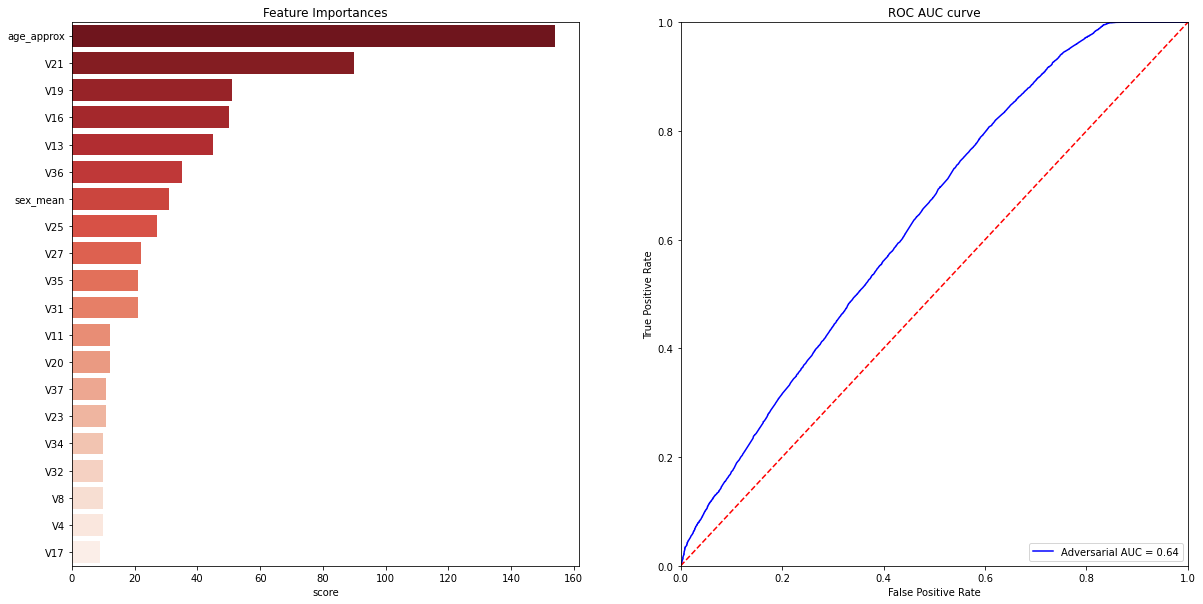

In [11]:
### Adversarial set
adv_train = train.copy()
adv_test = test.copy()
adv_train['dataset'] = 1
adv_test['dataset'] = 0

x_adv = pd.concat([adv_train, adv_test], axis=0)
y_adv = x_adv['dataset']

### Adversarial model
model_adv = XGBClassifier(**params, random_state=SEED)

model_adv.fit(x_adv[features], y_adv, eval_metric='auc', verbose=0)


### Preds
preds = model_adv.predict_proba(x_adv[features])[:, 1]


### Plot feature importance and ROC AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance
feature_importance = model_adv.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)

ax1.set_title('Feature Importances')
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r',
            ax=ax1)

# Plot ROC AUC curve
fpr_train, tpr_train, _ = roc_curve(y_adv, preds)
roc_auc_train = auc(fpr_train, tpr_train)

ax2.set_title('ROC AUC curve')
ax2.plot(fpr_train, tpr_train, color='blue', label='Adversarial AUC = %0.2f' % roc_auc_train)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# Visualize predictions

In [12]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 109
Train positive correct predictions: 44
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.094752,0.109177,0.090475,0.085084,0.081633,0.107391
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.042324,0.043172,0.033298,0.034273,0.044362,0.056514
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.117945,0.113578,0.096764,0.112028,0.104921,0.162434
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.106283,0.096742,0.100077,0.118847,0.090020,0.125727
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.053281,0.045839,0.052213,0.048237,0.054289,0.065826
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.048629,0.041094,0.043966,0.049557,0.049191,0.059336
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.042320,0.038367,0.037661,0.039229,0.039218,0.057128
7,ISIC_0075663,female,35.0,torso,unknown,0,0.114434,0.100886,0.113546,0.109183,0.125967,0.122588
8,ISIC_0075914,male,30.0,torso,unknown,0,0.044999,0.041939,0.040692,0.042141,0.042915,0.057306
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.050618,0.037696,0.050335,0.055768,0.048330,0.060961


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.055908,0.044812,0.058881,0.054386,0.060537,0.060924
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.220021,0.272824,0.170404,0.217976,0.199909,0.238993
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.190638,0.220694,0.165478,0.186573,0.218999,0.161446
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.173485,0.196478,0.182977,0.153549,0.173261,0.161162
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.133475,0.162298,0.094661,0.131810,0.128280,0.150324
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.239805,0.260807,0.189881,0.289933,0.251575,0.206831
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.110327,0.145541,0.095646,0.097095,0.093200,0.120152
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.297167,0.300603,0.261423,0.340735,0.252546,0.330530
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.494857,0.518446,0.451797,0.635295,0.384430,0.484315
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.086692,0.145696,0.095912,0.052446,0.051119,0.088288


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
238,ISIC_0189059,male,75.0,torso,nevus,0,0.517817,0.564917,0.506493,0.510443,0.471864,0.535369
707,ISIC_0314462,male,80.0,torso,unknown,0,0.504274,0.548769,0.479447,0.494933,0.461883,0.536337
714,ISIC_0316788,female,80.0,torso,unknown,0,0.530343,0.486083,0.530220,0.636978,0.488728,0.509708
1700,ISIC_0612624,male,80.0,head/neck,nevus,0,0.516547,0.515641,0.524829,0.521650,0.456486,0.564129
1742,ISIC_0624498,female,80.0,torso,melanoma,1,0.570289,0.628013,0.649290,0.357590,0.587260,0.629295
1840,ISIC_0653456,male,85.0,torso,nevus,0,0.580573,0.561301,0.619391,0.548406,0.537140,0.636627
2288,ISIC_0779920,female,75.0,upper extremity,melanoma,1,0.545810,0.547851,0.592149,0.536347,0.516329,0.536374
2638,ISIC_0889483,female,75.0,lower extremity,unknown,0,0.508612,0.552689,0.450064,0.464383,0.528017,0.547908
2852,ISIC_0952472,male,90.0,lower extremity,melanoma,1,0.581724,0.570648,0.681267,0.497707,0.729106,0.429892
3297,ISIC_1095325,female,75.0,lower extremity,unknown,0,0.507673,0.441560,0.608102,0.499504,0.448586,0.540614


# Visualize test predictions

In [13]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 39|10943
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.209388,0.207007,0.233268,0.197613,0.215271,0.193779
1,ISIC_0052349,male,40.0,lower extremity,0.114744,0.105342,0.117821,0.107545,0.102878,0.140135
2,ISIC_0058510,female,55.0,torso,0.043107,0.035339,0.044246,0.036599,0.045706,0.053646
3,ISIC_0073313,female,50.0,torso,0.030663,0.025778,0.024665,0.027947,0.034501,0.040425
4,ISIC_0073502,female,45.0,lower extremity,0.028671,0.024984,0.025795,0.023452,0.029578,0.039544
5,ISIC_0074618,male,50.0,lower extremity,0.118861,0.105997,0.134214,0.109602,0.113791,0.130703
6,ISIC_0076801,male,45.0,upper extremity,0.173282,0.181948,0.175417,0.179123,0.152146,0.177777
7,ISIC_0077586,male,50.0,lower extremity,0.030642,0.028473,0.030288,0.024355,0.030547,0.039544
8,ISIC_0082004,female,45.0,torso,0.028415,0.024984,0.025795,0.022173,0.029578,0.039544
9,ISIC_0082785,male,65.0,lower extremity,0.174649,0.203885,0.184004,0.158627,0.168050,0.158681


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
390,ISIC_0470699,male,90.0,torso,0.579082,0.620144,0.565616,0.510472,0.658720,0.540457
403,ISIC_0481105,male,80.0,torso,0.569161,0.630152,0.582748,0.471967,0.579900,0.581037
731,ISIC_0746818,male,70.0,torso,0.505412,0.471622,0.521686,0.494713,0.556318,0.482723
1577,ISIC_1505785,male,85.0,torso,0.515446,0.475106,0.488867,0.595815,0.452523,0.564922
2195,ISIC_2078598,male,80.0,torso,0.549012,0.526528,0.562017,0.595847,0.453102,0.607567
2964,ISIC_2766590,male,80.0,lower extremity,0.613211,0.718307,0.632485,0.506842,0.613165,0.595254
3034,ISIC_2828156,female,80.0,lower extremity,0.529049,0.493838,0.548688,0.533582,0.522712,0.546427
3650,ISIC_3426652,male,65.0,torso,0.521767,0.467650,0.647736,0.470687,0.542520,0.480241
3818,ISIC_3575990,female,80.0,lower extremity,0.539678,0.620765,0.596692,0.378795,0.527697,0.574442
3971,ISIC_3697615,male,75.0,torso,0.504766,0.604630,0.445459,0.435962,0.523832,0.513945


# Test set predictions

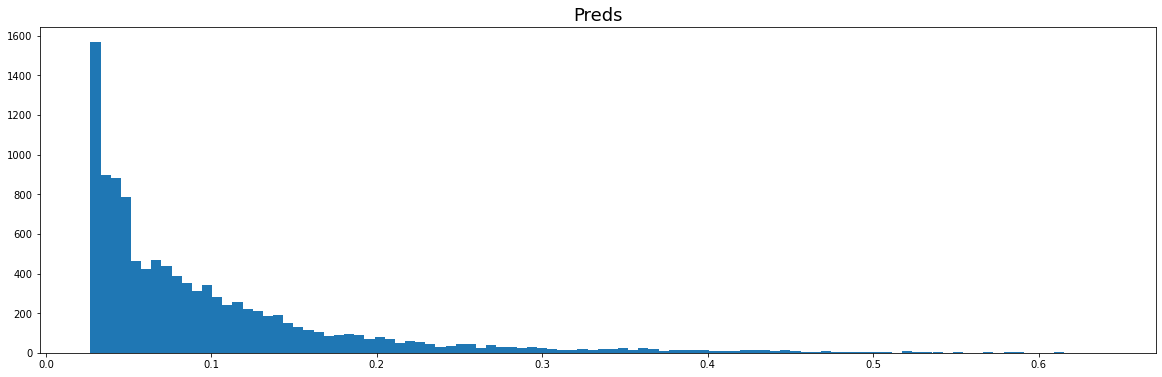

,image_name,target
0,ISIC_0052060,0.209388
1,ISIC_0052349,0.114744
2,ISIC_0058510,0.043107
3,ISIC_0073313,0.030663
4,ISIC_0073502,0.028671
5,ISIC_0074618,0.118861
6,ISIC_0076801,0.173282
7,ISIC_0077586,0.030642
8,ISIC_0082004,0.028415
9,ISIC_0082785,0.174649


,target
count,10982.000000
mean,0.098456
std,0.085335
min,0.026925
25%,0.041360
50%,0.069860
75%,0.122567
max,0.640151


In [14]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']

fig = plt.subplots(figsize=(20, 6))
plt.hist(submission['target'], bins=100)
plt.title('Preds', size=18)
plt.show()

display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)